In [2]:
from importlib import reload
import flymovie as fm
import cnn_models.siamese_cnn as cn
import cnn_models.evaluate_models as ev
from flymovie.simnuc import Sim
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import sklearn
import tempfile
import pickle
import tensorflow as tf
import umap
from importlib import reload
from sklearn.manifold import TSNE
import scipy.ndimage as ndi
import skimage as ski
%load_ext autoreload
%autoreload 2

In [47]:
import sklearn.decomposition
def pca3d(embeddings, alpha=1, use_combined=False):
    combined = np.vstack(embeddings)
    pca = sklearn.decomposition.PCA(n_components=3)
    if use_combined:
        pca.fit(combined)
    else:
        pca.fit(embeddings[0])
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    for i in range(len(embeddings)):
        if i == 0:
            alpha_plot = 0
        else:
            alpha_plot = alpha
        tfm = pca.transform(embeddings[i])
        ax.scatter(tfm[:,0], tfm[:,1], tfm[:,2], 
                alpha=alpha_plot)
    
def save_list(l, outfolder):
    if not os.path.exists(outfolder):
        os.mkdir(outfolder)
    count = 1
    for arr in l:
        
        fake_id = 'aaa_'
        fake_params = [str(round(x, 2)) for x in np.random.random(9)]
        filepath = os.path.join(outfolder, fake_id + '_'.join(fake_params) + '.pkl')
        fm.save_pickle(arr, filepath)
        count += 1

def load_folder(folder):
    ims = []
    for f in sorted(os.listdir(folder)):
        if f[0] == '.':
            continue
        im = fm.load_pickle(os.path.join(folder, f))
        ims.append(im)
    return ims

def process(mat, n):
    v = mat.copy()
    # Subtract mean.
    v = v - v.mean(axis=0)
    # Fit n PCA components.
    pca = sklearn.decomposition.PCA(n_components=n)
    pca.fit(v)
    # Subtract off the first n components.
    tfm = pca.transform(v)
    print(tfm.shape)
    for i in range(n):
        vp = np.outer(tfm[:,i], pca.components_[i])
        v = v - vp
    return v

# Same, written with vectors. Confirmed output is the same as process.
def process2(mat_in, n):
    mat = mat_in.copy()
    # Subtract mean.
    mat = mat - mat.mean(axis=0)
    # Fit n PCA components.
    pca = sklearn.decomposition.PCA(n_components=n)
    pca.fit(mat)
    # Subtract off the first n components.
    #tfm = pca.transform(v)
    for r in range(mat.shape[0]):
        v = mat[r]
        for i in range(n):
            comp = pca.components_[i]
            #comp = np.expand_dims(comp, 1) # column vector
            vp = np.dot(comp, v)
            vp = vp * comp
            v = v - vp

        mat[r, :] = v
    return mat

def match_idxs(files, pattern):
    return [x for x in np.arange(len(files)) if re.search(pattern, files[x])]


def combine_embeddings(outfilestem, infilestems):

    # Merge embeddings.
    merged = np.genfromtxt(fname=infilestems[0] + '_embeddings.tsv', delimiter="\t")
    filenames = np.genfromtxt(fname=infilestems[0] + '_filenames.tsv', delimiter="\t", dtype='str')

    for n in range(1, len(infilestems)):
        new = np.genfromtxt(fname=infilestems[n] + '_embeddings.tsv', delimiter="\t")
        merged = np.vstack((merged, new))

        newfiles = np.genfromtxt(fname=infilestems[n] + '_filenames.tsv', dtype='str', delimiter='\t')
        filenames = np.concatenate((filenames, newfiles))

    np.savetxt(outfilestem + '_embeddings.tsv', merged, delimiter='\t')
    np.savetxt(outfilestem + '_filenames.tsv', filenames, delimiter='\t', fmt="%s")
    
    return merged, filenames


def save_embeddings(outfilepath, embeddings, filenames):
    np.savetxt(outfilepath + '_embeddings.tsv', embeddings, delimiter='\t')

    with open(outfilepath + '_filenames.tsv', 'w') as filenames_file:
        for f in filenames:
            if f[0] == '.':
                continue
            filenames_file.write(f + '\n')

def norm(im):
    mask = np.where(im > 0, True, False)
    masked_vals = im[mask]
    im_normed = (im - np.min(masked_vals)) / (np.max(masked_vals) - np.min(masked_vals)) * (2 ** 16)
    return np.where(mask, im_normed, 0)

In [4]:
weights_file = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/trained_models/checkpoint_final_mix_real_sim_2'
base_cnn = cn.make_base_cnn_3d(image_shape=(34,100,100), nlayers=8)
embedding8 = cn.make_embedding(base_cnn)
embedding8.load_weights(weights_file)

weights_file = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/trained_models/checkpoint_final_mix_real_sim_3_34layer'
base_cnn = cn.make_base_cnn_3d(image_shape=(34,100,100), nlayers=34)
embedding34 = cn.make_embedding(base_cnn)
embedding34.load_weights(weights_file)

2022-04-05 17:35:08.979496: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
#e = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/all', embedding, return_params=False)
#e, ims, files = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/set2', embedding, return_params=False, return_stack=True)
#e, ims, files = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/set2/bcd', embedding, return_params=False, return_stack=True)
#e_h2b, ims_h2b = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/h2b', embedding, return_params=False, return_stack=True)
e = np.genfromtxt('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/mix3_embeddings.tsv', delimiter='\t')
files = np.genfromtxt('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/mix3_filenames.tsv', delimiter='\t', dtype='str')

In [ ]:
#pca = sklearn.decomposition.PCA(n_components=1)
#pca.fit(e)
#pca.explained_variance_ratio_

e_processed = e - e.mean(axis=0)
e_processed = process(e_processed, 1)

#e_processed= e

In [ ]:
#dr = TSNE(n_components=2, learning_rate='auto', perplexity=50, init='random').fit_transform(e_processed)
reducer = umap.UMAP(n_neighbors=100, min_dist=0.5).fit(e_processed)
dr = reducer.transform(e_processed)

In [ ]:
#reducer = umap.UMAP(n_neighbors=10, min_dist=0.1).fit(e_processed)
#dr = reducer.transform(e_processed)
i=match_idxs(files, 'rpb1_2')
j=match_idxs(files, 'rpb1_sim')
k=match_idxs(files, 'h2b_2')
l=match_idxs(files, 'h2b_sim')
m=match_idxs(files, 'zld_2')
n=match_idxs(files, 'zld_sim')

#print(np.array(files)[i])
plt.figure(figsize=(10,10))
#plt.scatter(dr[:,0], dr[:,1], c="blue", alpha=0.1)
plt.scatter(dr[i,0], dr[i,1], c="orange", alpha=0.5)
plt.scatter(dr[j,0], dr[j,1], c="red", alpha=0.5)
plt.scatter(dr[k,0], dr[k,1], c="blue", alpha=0.5)
plt.scatter(dr[l,0], dr[l,1], c="green", alpha=0.5)
plt.scatter(dr[m,0], dr[m,1], c="purple", alpha=0.5)
plt.scatter(dr[n,0], dr[n,1], c="gold", alpha=0.5)

#fm.viewer(ims[j].max(axis=1) * 1000, 5)

In [ ]:
#kernel=fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/PSFs/psf_20220210_21x25x25pixels_100x50x50voxel.pkl')
masks_og = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_masks/mask_files/nc13_1.pkl')

mask = Sim.make_spherical_mask(100,100,100,42)
sim = Sim(mask)
eroded_coords = sim.get_eroded_coordinates(9)
hlb_possible_coords = list(zip(eroded_coords[0], eroded_coords[1], eroded_coords[2]))

In [ ]:
outfolder = ''
nreps = 1
nfree_rng = [18_000, 18_000]
hlb_diam_rng = [16,16]
hlb_nmols_rng = [400,400]
n_clusters_rng = [1,1]
cluster_diam_mean_rng = [2,2] 
cluster_diam_var_rng = [0.7,0.7]
cluster_nmols_mean_rng = [4,4]
cluster_nmols_var_rng = [3,3]
noise_sigma_rng = [0.6,0.6]
dims_init=(85, 85, 85)
dims_kernel=(100,50,50)
dims_final=(250,85,85)

hlb_coords = [hlb_possible_coords[x] for x in np.random.choice(len(hlb_possible_coords), 2)]
#hlb_coords = [(12, 60, 38), (21, 57, 41)]
sims = []
nsims=3
for _ in range(nsims):
    masks = masks_og[np.random.choice(np.arange(len(masks_og)), nsims)]
    sim = fm.sim_rpb1(masks, kernel, outfolder, nreps, nfree_rng, hlb_diam_rng, 
        hlb_nmols_rng, n_clusters_rng, cluster_diam_mean_rng, 
        cluster_diam_var_rng, cluster_nmols_mean_rng, cluster_nmols_var_rng,
        noise_sigma_rng, hlb_coords, dims_init, 
        dims_kernel, dims_final, return_sim=True, mask_nuclei=True)
    sims.append(sim.im)

with tempfile.TemporaryDirectory() as tdir:
    for i in range(len(sims)):
        tf = os.path.join(tdir, str(i) + '_1.pkl')
        fm.save_pickle(sims[i], tf)
        
    e_new = ev.embed_images(tdir, embedding, return_params=False, return_stack=False)[0]

dr_new = reducer.transform(e_new)
plt.figure(figsize=(10,10))
plt.scatter(dr[:,0], dr[:,1], c="gray", alpha=0.1)
plt.scatter(dr_new[:,0], dr_new[:,1], c="red", alpha=1)

fm.viewer(np.array(sims), 5)


In [ ]:
e.shape

In [ ]:
e2 = dr.copy()
e2 = np.hstack((e2, np.zeros((e2.shape[0],1))))
for d in range(28, 41):
    i=match_idxs(files, 'em2-' + str(d))
    e2[i,-1] = d
    
plt.scatter(e2[:,0], e2[:,1], c=e2[:,2], alpha=1)


In [104]:
e, ims = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/set2/bcd', embedding8, return_params=False, return_stack=True, return_files=False)


(353, 34, 100, 100, 1)


In [95]:
save_embeddings('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1-sims', e, files)

NameError: name 'e' is not defined

In [ ]:
em, fs = combine_embeddings(
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/reals_rpb1_h2b_zld',
[
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1_real', 
#'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1_sims', 
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/h2b_real',
#'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/h2b_sims',
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/zld_real',
#'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/zld_sims'
]
)

In [ ]:
def sortcolors(embeddings, files, target_tag, n_neighbors=None):
    if n_neighbors is None:
        n_neighbors = embeddings.shape[0]
    count = 0
    tags = []
    tag_ids = {}
    for f in files:
        tag = f.split('_')[0]
        if tag not in tag_ids:
            tag_ids[tag] = count
            count += 1
        tags.append(tag)
    
    tags = np.array(tags)
    tag_idxs = [x for x in np.arange(len(files)) if re.search(target_tag, files[x])]
    
    mat = np.ndarray((0, n_neighbors))
    for idx in tag_idxs:
        dists = np.sum((embeddings - embeddings[idx]) ** 2, axis=1)
        tags_sorted = tags[np.argsort(dists)[:n_neighbors]]
        ids = [tag_ids[x] for x in tags_sorted] 
        ids = np.expand_dims(np.array(ids), axis=0)
        mat = np.vstack((mat, ids))  
    
    return mat, tag_ids
    
#mat = sortcolors(em, fs, 'rpb',30)
        


In [ ]:
mat, tag_ids = sortcolors(em, fs, 'h2b')
print(tag_ids)
sns.heatmap(mat)
plt.savefig('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/tempfigs/h2b.png', dpi=300)

In [ ]:
em, fs = combine_embeddings(
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/reals_rpb1_h2b_zld',
[
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1_sims', 
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/h2b_sims',
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/zld_sims'
]
)

In [ ]:
mat, ids = sortcolors(em, fs, 'h2b')
print(ids)
plt.figure(figsize=(20,20))
sns.heatmap(mat)

In [ ]:
em, fs = combine_embeddings(
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/reals_rpb1_h2b_zld',
[
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1-real', 
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1-sims', 
#'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/h2b-real',
#'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/h2b-sims',
#'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/zld-real',
#'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/zld-sims'
]
)

mat, tags = sortcolors(em, fs, 'rpb1-real')
print(tags)
plt.figure(figsize=(20,20))
sns.heatmap(mat)

In [ ]:
save_embeddings('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/mix-rpb1-real-sims', em, fs)

In [ ]:
em, fs = combine_embeddings(
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/reals_rpb1_h2b_zld',
[
#'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1-real', 
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1-sims', 
#'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/h2b-real',
#'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/h2b-sims',
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/zld-real',
#'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/zld-sims'
]
)

mat, tags = sortcolors(em, fs, 'rpb1-sim')
print(tags)
plt.figure(figsize=(20,20))
sns.heatmap(mat)
plt.savefig('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/tempfigs/temp.png', dpi=300)

In [ ]:
em, fs = combine_embeddings(
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/temp',
[
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1-real', 
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/h2b-real',
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/zld-real',
]
)

In [591]:
len(files)

1205

In [ ]:
#plt.hist(mins, bins=100, density=True, alpha=0.5);
plt.hist(diff_tag, bins=100, density=True, alpha=0.5);
plt.hist(same_ds, bins=100, density=True, alpha=0.5);

In [ ]:
em, fs = combine_embeddings(
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/temp',
[
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1-real', 
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1-sims'
]
)

In [ ]:
def find_in_radius(em1, files1, em2, files2, r):
    def dists_arr_to_row(arr, row):
        dists_sq = np.sum((arr - row) ** 2, axis=1)
        dists = np.sqrt(dists_sq)
        return dists

    tags = []
    datasets = []
    for f in files:
        tag, dataset = f.split('_')[:2]
        tags.append(tag)
        datasets.append(dataset)

    tags = np.array(tags)
    datasets = np.array(datasets)
    hits = {}

    for i in range(len(files)):
        if i % 250 == 0:
            print(i)

        file = files[i]
        tag = tags[i]
        em_ref = em[i]

        if tag == tag1:
            dists = dists_arr_to_row(em, em_ref)
            good_uns = (dists <= r) & (tags == tag2)
            good_files = files[good_uns]
            if len(good_files) > 0:
                hits[file] = good_files

    return hits
    
find_in_radius(em3, fs3, em1, fs1, 1)

In [ ]:
em1, fs1 = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/embeddings_rpb1-sims-20220328_uTRwkGyn_left_mix_real_sim_2.pkl')

In [ ]:
save_embeddings('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/embeddings_rpb1-sims-20220328_uTRwkGyn_left_mix_real_sim_2', em, fs)

In [ ]:
em2, fs2 = combine_embeddings(
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/temp',
[
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1-real', 
#'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/embeddings_rpb1-sims-20220328_uTRwkGyn_left_mix_real_sim_2'
]
)

In [150]:
def find_in_radius(em1, files1, em2, files2, r):
    def dists_arr_to_row(arr, row):
        dists_sq = np.sum((arr - row) ** 2, axis=1)
        dists = np.sqrt(dists_sq)
        return dists

    hits = np.array([])
    files1 = np.array(files1)
    files2 = np.array(files2)

    for i in range(len(files1)):
        if i % 250 == 0:
            print(i)

        file1 = files1[i]
        em_ref = em1[i]

        
        dists = dists_arr_to_row(em2, em_ref)
        good_uns = dists <= r
        good_files2 = files2[good_uns]
        if len(good_files2) > 0:
            hits = np.concatenate((hits, good_files2))
    hits = np.unique(hits)

    params = np.ndarray((0, len(hits[0].split('_')) - 2))
    for hit in hits:
        p = hit.split('_')[1:-1]
        p = np.expand_dims(p, axis=0)
        params = np.vstack((params, p))

    return params

#params3 = find_in_radius(em3, fs3, em1, fs1, 1)

In [ ]:
def plot_hists(p):
    #fig, ax = plt.subplots(1, p.shape[1])
    p = p.astype(float)
    for i in range(p.shape[1]):
        print(np.min(p[:,i]), np.max(p[:,i]))
plot_hists(params_all)

In [557]:
def plot_hists(p1, p2):
    var_names=['nfree', 'hlb_diam', 'hlb_mols', 'n_clusters', 'cluster_diam_mean', 'cluster_diam_var', 'cluster_nmols_mean', 'cluster_nmols_var', 'noise_sigma']
    fig, ax = plt.subplots(1, p.shape[1], figsize=(30,5))
    p1 = p1.astype(float)
    p2 = p2.astype(float)
    for i in range(p1.shape[1]):
        ax[i].hist(p1[:,i], range=(np.min(p2[:,i]),np.max(p2[:,i])), bins=25);
        ax[i].set_title(var_names[i])


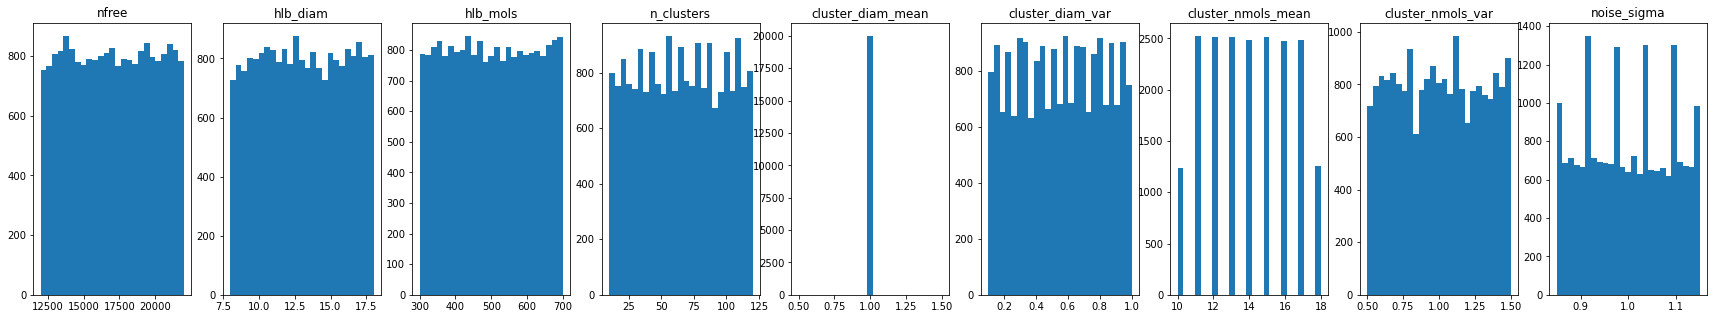

In [555]:
plot_hists(params_all, params_all)

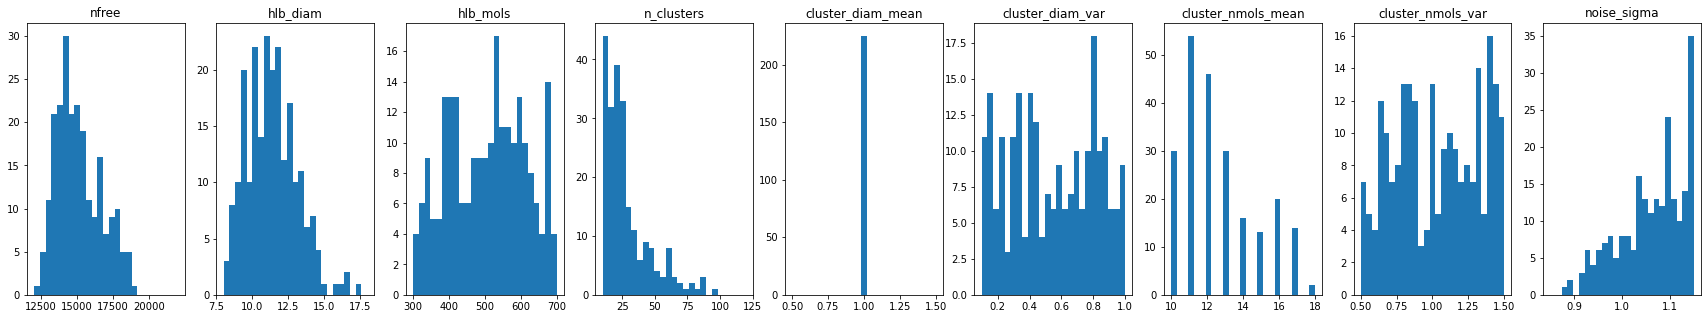

In [556]:
plot_hists(params3, params_all)

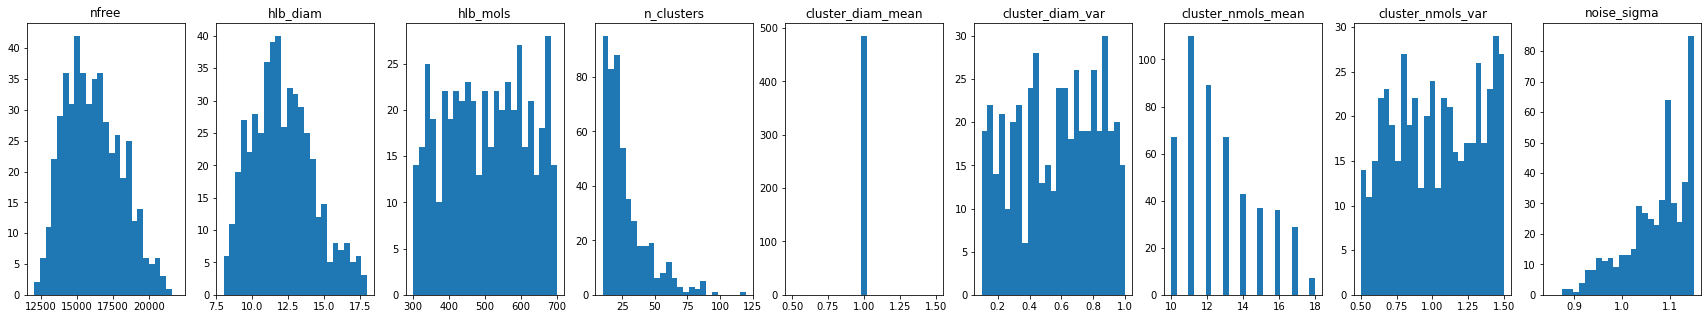

In [558]:
plot_hists(params2, params_all)

In [566]:
p3 = pd.DataFrame(params3.astype(float), columns=var_names)


,nfree,hlb_diam,hlb_mols,n_clusters,cluster_diam_mean,cluster_diam_var,cluster_nmols_mean,cluster_nmols_var,noise_sigma
0,14007.0,10.38,453.0,15.0,1.0,0.56,10.0,0.66,0.96
1,13173.0,12.92,556.0,27.0,1.0,0.55,13.0,1.36,0.96
2,17932.0,11.57,610.0,16.0,1.0,0.86,11.0,1.04,1.14
3,17979.0,12.70,697.0,20.0,1.0,0.14,11.0,1.48,1.11
4,16757.0,12.15,540.0,29.0,1.0,0.87,11.0,1.03,0.97
...,...,...,...,...,...,...,...,...,...
220,13538.0,10.77,362.0,30.0,1.0,0.50,12.0,1.43,1.06
221,14519.0,13.37,680.0,79.0,1.0,0.47,10.0,0.73,1.15
222,14534.0,8.56,426.0,59.0,1.0,0.12,11.0,0.53,1.10
223,12710.0,13.25,670.0,30.0,1.0,0.53,12.0,1.47,1.07


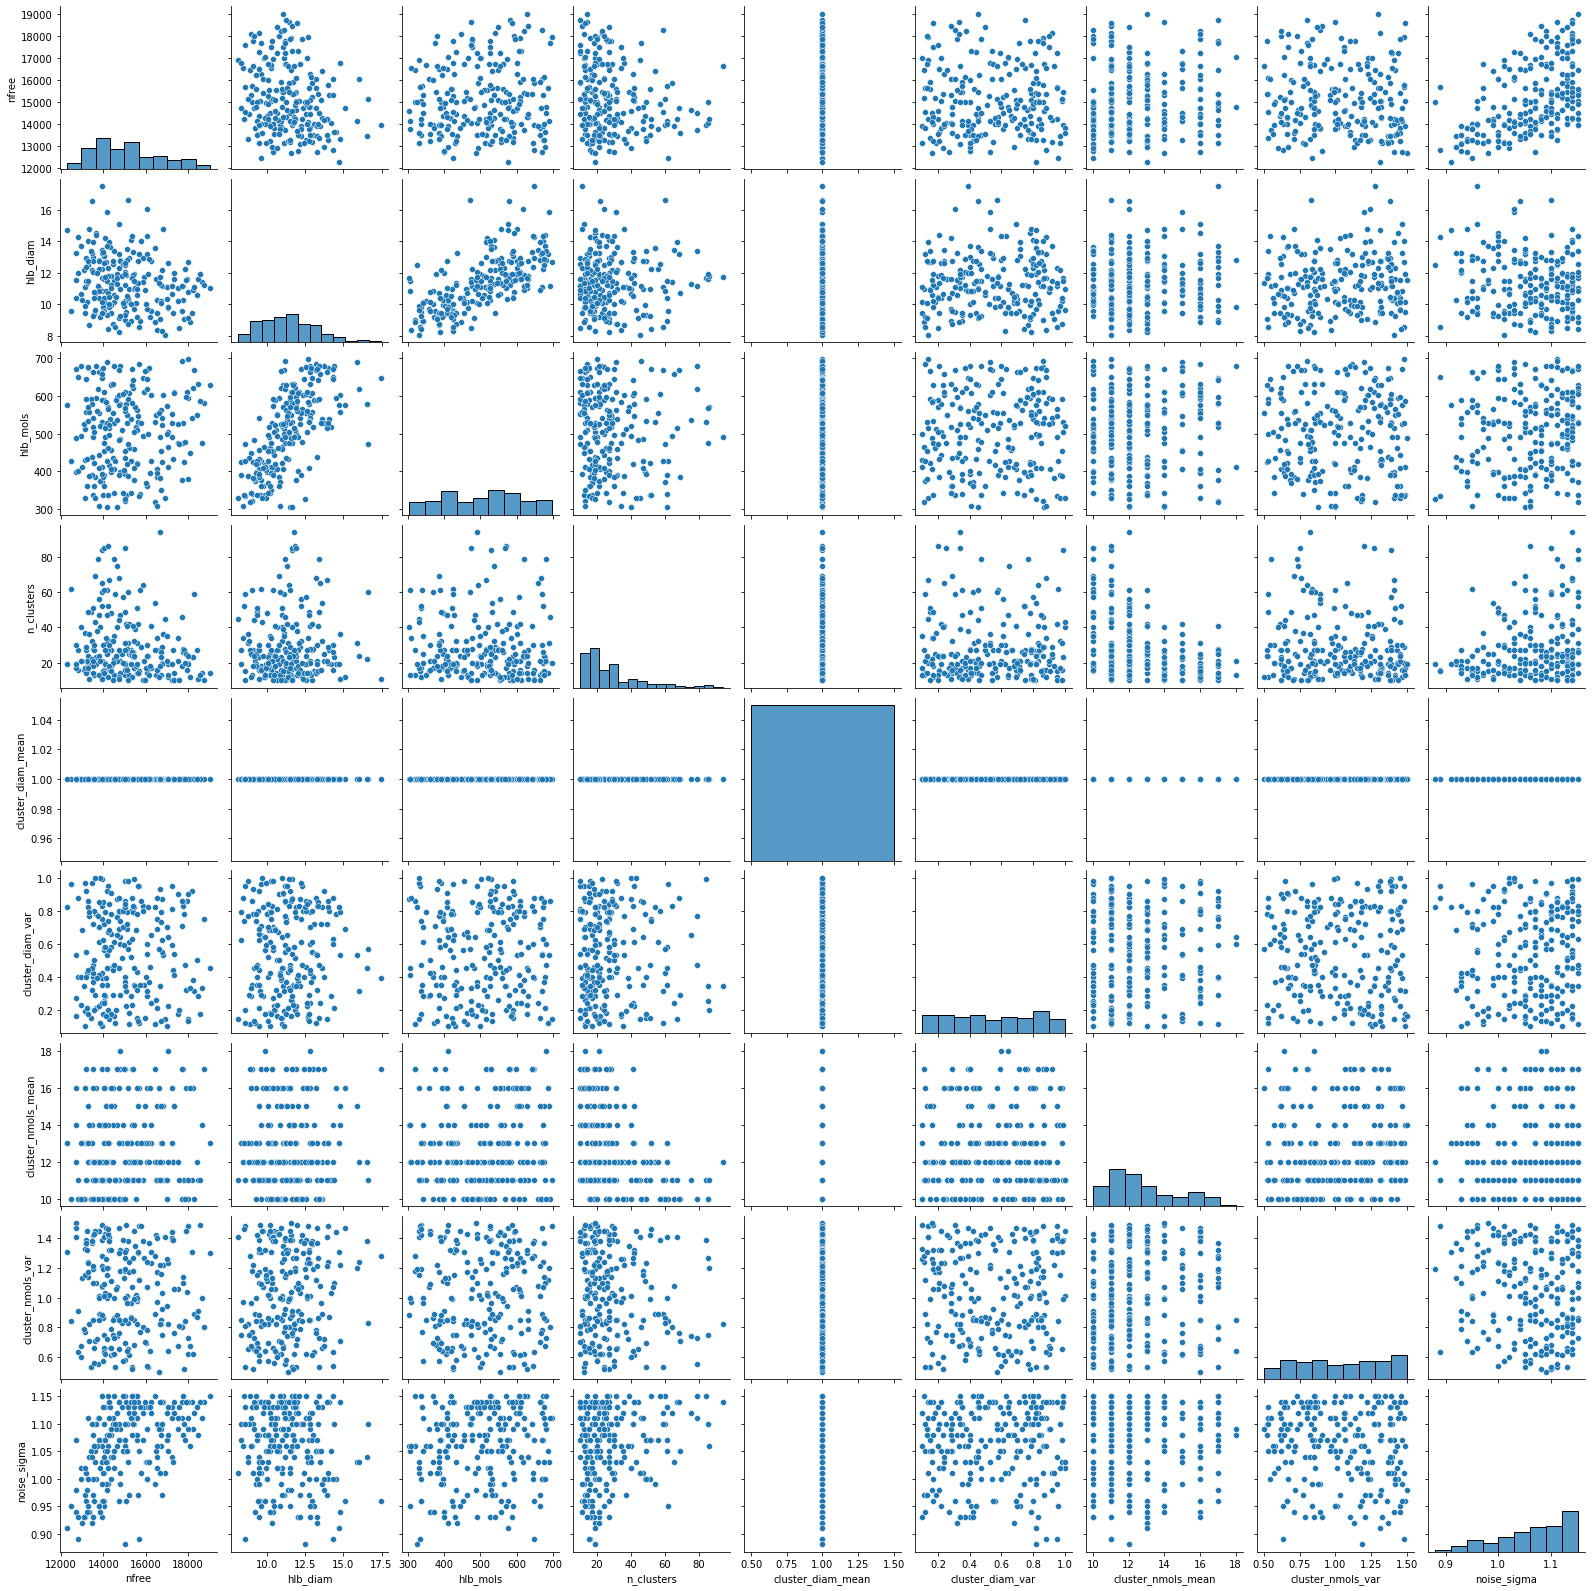

In [567]:
sns.pairplot(p3)

In [105]:
em, files = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/set2/h2b', embedding34, return_params=False, return_stack=False, return_files=True)


(1205, 34, 100, 100, 1)


In [111]:
em_x, files_x = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/rpb1-nc14-evolution', embedding34, return_params=False, return_stack=False, return_files=True, batch_size=100)


In [577]:
save_embeddings('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/h2b-real-34layer', em, files)

In [608]:
em34, files34 = combine_embeddings('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/reals_rpb1_h2b_zld_34layer',
(
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1-real-34layer',
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/zld-real-34layer',
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/h2b-real-34layer'
)
)

em8, files8 = combine_embeddings('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/reals_rpb1_h2b_zld_8layer',
(
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1-real',
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/zld-real',
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/h2b-real'
)
)

In [197]:
def get_dist_distros(em, files):
    def dists_arr_to_row(arr, row):
        dists_sq = np.sum((arr - row) ** 2, axis=1)
        dists = np.sqrt(dists_sq)
        return dists

    tags = []
    datasets = []
    nucs = []
    for f in files:
        tag, dataset, nuc = f.split('_')[:3]
        tags.append(tag)
        datasets.append(dataset)
        nucs.append(nuc)
    
    tags = np.array(tags)
    datasets = np.array(datasets)
    nucs = np.array(nucs)
    dists_same_ds = np.array([])
    dists_same_nuc = np.array([])
    dists_diff_tag = np.array([])

    for i in range(len(files)):
        if i % 250 == 0:
            pass
            #print(i)
        tag = tags[i]
        dataset = datasets[i]
        nuc = nucs[i]
        em_ref = em[i]

        em_diff_tag = em[tags != tag]
        em_same_ds = em[datasets == dataset]
        em_same_nuc = em[(datasets == dataset) & (nucs == nuc)]

        if np.count_nonzero(em_diff_tag) > 0:
            all_dists_diff_tag = dists_arr_to_row(em_diff_tag, em_ref)
            sampled_dists_diff_tag = np.random.choice(all_dists_diff_tag, size=100, replace=False)
            dists_diff_tag = np.concatenate((dists_diff_tag, sampled_dists_diff_tag))

        dists_same_ds = np.concatenate((dists_same_ds, dists_arr_to_row(em_same_ds, em_ref)))

        dists_same_nuc = np.concatenate((dists_same_nuc, dists_arr_to_row(em_same_nuc, em_ref)))

    dists_same_ds = dists_same_ds[dists_same_ds > 0]
    dists_same_nuc = dists_same_nuc[dists_same_nuc > 0]

    return dists_diff_tag, dists_same_ds, dists_same_nuc

def get_row_row_dists(arr):
    dists = []
    for i in range(arr.shape[0]):
        sub_arr = np.vstack((arr[:i], arr[i+1:]))
        sub_dists = np.sqrt(np.sum((sub_arr - arr[i]) ** 2, axis=1))
        dists.append(sub_dists)
    return np.array(dists).flatten()
    
#a = get_dist_distros(em, files)

In [609]:
diff_tag34, same_ds34, same_nuc34 = get_dist_distros(em34, files34)
diff_tag8, same_ds8, same_nuc8 = get_dist_distros(em8, files8)

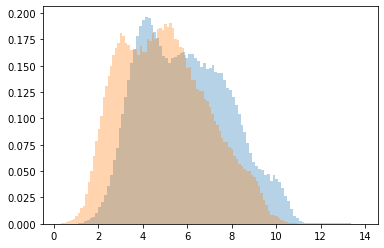

In [611]:
plt.hist(diff_tag8, density=True, alpha=0.33, bins=100);
plt.hist(diff_tag34, density=True, alpha=0.33, bins=100);

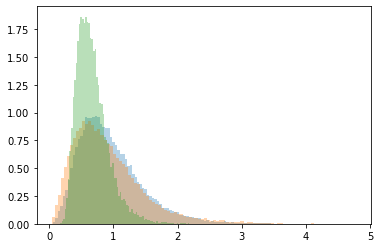

In [631]:
plt.hist(same_ds8, density=True, alpha=0.33, bins=100);
plt.hist(same_ds34, density=True, alpha=0.33, bins=100);
plt.hist(dists, density=True, alpha=0.33, bins=100);

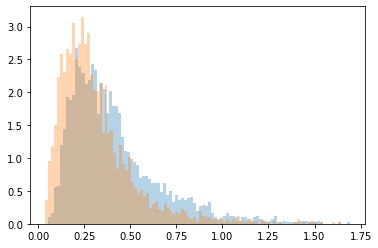

In [630]:
plt.hist(same_nuc8, density=True, alpha=0.33, bins=100);
plt.hist(same_nuc34, density=True, alpha=0.33, bins=100);

In [622]:
em_l, files_l = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/embeddings_rpb1-sims-20220328_uTRwkGyn_left_mix_real_sim_2.pkl')
em_r, files_r = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/embeddings_rpb1-sims-20220328_uTRwkGyn_right_mix_real_sim_2.pkl')

In [628]:
dists = np.sqrt(np.sum((em_l - em_r) ** 2, axis=1))

In [646]:
im = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/rpb1-nc14-evolution/rpb1-real_20220318-rpb1-gfp-em1-08_4_0.pkl')
fm.viewer(im, 5)

interactive(children=(Dropdown(description='Color', index=2, options=('prism', 'gray_r', 'cividis', 'inferno',…

### Workflow

1. Embed reals 

2. Collect masks from the dataset

3. Simulate some guess at a parameter range

4. Embed sims

5. Assess parameters of matches, go to step 3



In [360]:
nucs = load_folder('/Users/michaelstadler/Desktop/tmp')
nucs = np.array(nucs)
masks_og = load_folder('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_masks/rpb1_match/em1-08')
for i in range(len(masks_og)):
    masks_og[i] = ndi.zoom(masks_og[i],(100/34, 1, 1), order=0)
masks_og = np.array(masks_og)

kernel=fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/PSFs/psf_20220210_21x25x25pixels_100x50x50voxel.pkl')

In [365]:
outfolder = '/Users/michaelstadler/Desktop/tmp'
nreps = 1
ntotal_rng = [30_000, 30_000]
hlb_diam_rng = [12,12]
hlb_nmols_rng = [1,1]
n_clusters_rng = [1,1]
cluster_diam_mean_rng = [2,2] 
cluster_diam_var_rng = [0.7,0.7]
cluster_nmols_mean_rng = [4,4]
cluster_nmols_var_rng = [3,3]
noise_sigma_rng = [10,10]
dims_init=(85, 85, 85)
dims_kernel=(100,50,50)
dims_final=(250,85,85)

#hlb_coords = [hlb_possible_coords[x] for x in np.random.choice(len(hlb_possible_coords), 2)]
hlb_coords = [(12, 60, 38), (51, 57, 41)]
sims = []
nsims=1
for _ in range(nsims):
    masks = masks_og[np.random.choice(np.arange(masks_og.shape[0]), nsims)]
    sim = fm.sim_rpb1(masks, kernel, outfolder, nreps, ntotal_rng, hlb_diam_rng, 
        hlb_nmols_rng, n_clusters_rng, cluster_diam_mean_rng, 
        cluster_diam_var_rng, cluster_nmols_mean_rng, cluster_nmols_var_rng,
        noise_sigma_rng, hlb_coords, dims_init, 
        dims_kernel, dims_final, return_sim=True, mask_nuclei=False)
    sims.append(sim.im)

n = 4
fm.viewer([norm(nucs[n]), norm(sim.im)], 5)

interactive(children=(Dropdown(description='Color', index=4, options=('gray', 'inferno', 'prism', 'plasma', 'c…

## Ruminating on signal/noise

I'm thinking about the intensity of GFPs. Obviously the raw number doesn't matter. What matters is signal to noise, which is a function of the intensity of GFP molecules, the number of them, and the noise of the system. I have the n-mers. Is there a way I can back out the GFP/noise ratio from these? 

Maybe it's enough to just remove a degree of freedom. If I can get an estimate of the number of molecules in a nucleus, I can then arbitrarily fix the GFP intensity and then adjust a single parameter (noise), or vice versa, to match simulations to real images. 

Can I use the n-mers to do this? OK here's a thought. I tried measuring the PSF directly off the 120-mers but this failed because they move. But I have the PSF of the microscope. The diffracction pattern of the n-mers should just be a multiple of that, right? So if I can find a way to fit the intensity of the observed n-mer spots, I can generate a "60-mer PSF". I can then divide to get 30-mer, etc. Or I can just create a lattice of evenl spaced n-mers, sum the PSFs (effectively doing convolution), and figure out how many GFPs per unit volume to give the same mean intensity as a real nucleus, then multiply by the volume of the nucleus to get the number of molecules. 

Actually, I __*think*__ that once you have an adjusted PSF (the result of convolution of the microcsope with n GFPs), you can just sum the total signal in the nucleus and divide by the sum of the PSF/kernel to get an estimate of the number of molecules.

This will of course be sensitive to laser power, detector gain, etc.

#### Alternately

Is there a way to directly get this *from the sims*? The reason this matters is that different paths to a total mean fluorescence gives you different images. For example, 1,000 molecules at noise level 1 and 10,000 molecules at noise level 10 will look different (I think). If we just take Zelda C-terminal and assume that it's a population of entirely freely diffusing (randomly distributed) molecules, can we try different numbers of molecules and noise sigmas as see which one matches the real images? This could give us a calibration for GFP intensity or noise.

In [69]:
outfolder = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/zld-cterm'
nreps = 1
#nfree_rng = [17_600, 17_600]
hlb_diam_rng = [12,12]
hlb_nmols_rng = [0,0]
n_clusters_rng = [0,0]
cluster_diam_mean_rng = [1,1] 
cluster_diam_var_rng = [0.01,0.01]
cluster_nmols_mean_rng = [4,4]
cluster_nmols_var_rng = [3,3]
#noise_sigma_rng = [9,9]
dims_init=(85, 85, 85)
dims_kernel=(100,50,50)
dims_final=(250,85,85)

#hlb_coords = [hlb_possible_coords[x] for x in np.random.choice(len(hlb_possible_coords), 2)]
hlb_coords = [(12, 60, 38), (51, 57, 41)]
sims = []
nsims=1
for nfree in range(1_000, 30_000, 250):
    for sigma in range(0.1, 10, 0.1)
    masks = masks_og[np.random.choice(np.arange(masks_og.shape[0]), nsims)]
    sim = fm.sim_rpb1(masks, kernel, outfolder, nreps, nfree_rng, hlb_diam_rng, 
        hlb_nmols_rng, n_clusters_rng, cluster_diam_mean_rng, 
        cluster_diam_var_rng, cluster_nmols_mean_rng, cluster_nmols_var_rng,
        noise_sigma_rng, hlb_coords, dims_init, 
        dims_kernel, dims_final, return_sim=False, mask_nuclei=True)



In [83]:
im = nucs[0].copy()
im_p = np.random.normal(np.zeros_like(nucs[0]))
fm.viewer(im_p, 5)

interactive(children=(Dropdown(description='Color', index=4, options=('gray', 'inferno', 'prism', 'plasma', 'c…

In [143]:
em_r, files_r = ev.embed_images('/Users/michaelstadler/Desktop/tmp', embedding34, return_params=False, return_stack=False, return_files=True, batch_size=100)


In [144]:
save_embeddings('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/zld-cterm_20220321-em1-34layer', em_r, files_r)

In [145]:
em_s, files_s = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/embeddings_zld-cterm-sims-20220406_ofzoALMZ.pkl')

In [146]:
save_embeddings('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/embeddings_zld-cterm-sims-20220406_ofzoALMZ', em_s, files_s)

In [147]:
combine_embeddings('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/zld-cterm-real-sim-mix',
    [
        '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/embeddings_zld-cterm-sims-20220406_ofzoALMZ',
        '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/zld-cterm_20220321-em1-34layer'
    ])

(array([[ 0.32740703, -0.00901158, -0.05560022, ..., -0.04871326,
         -0.28932983,  0.09387612],
        [ 0.17918327, -0.19663301,  0.01318036, ...,  0.03094666,
         -0.24186195,  0.18581395],
        [ 0.30682898, -0.01968426, -0.05211642, ..., -0.0455275 ,
         -0.29066902,  0.09644148],
        ...,
        [ 0.01942141, -0.25136396,  0.12416817, ...,  0.11116639,
         -0.14368142,  0.15461376],
        [ 0.01569646, -0.25374699,  0.12263517, ...,  0.10793439,
         -0.14549044,  0.15938687],
        [ 0.02940951, -0.24449453,  0.11072986, ...,  0.10680834,
         -0.15532793,  0.15749334]]),
 array(['AAW_2992_10.74_0_0_1_0.76_14_0.75_7.43_rep0.pkl',
        'AAZ_13018_13.15_0_0_1_0.44_17_1.04_4.7_rep0.pkl',
        'AAd_5073_16.73_0_0_1_0.54_14_0.72_5.73_rep0.pkl', ...,
        'zld-cterm_20220321-zld-cterm-gfp-em1-01_9_1.pkl',
        'zld-cterm_20220321-zld-cterm-gfp-em1-01_9_3.pkl',
        'zld-cterm_20220321-zld-cterm-gfp-em1-01_9_5.pkl'], dtype='<U48')

In [173]:
p = find_in_radius(em_r, files_r, em_s, files_s, 0.3)

0


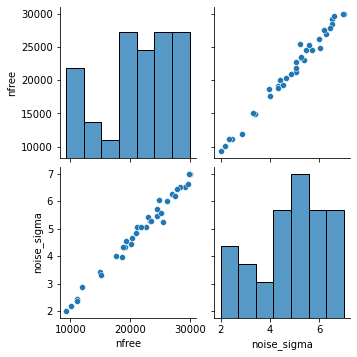

In [174]:
var_names=['nfree', 'hlb_diam', 'hlb_mols', 'n_clusters', 'cluster_diam_mean', 'cluster_diam_var', 'cluster_nmols_mean', 'cluster_nmols_var', 'noise_sigma']

p = pd.DataFrame(p.astype(float), columns=var_names)
sns.pairplot(p[['nfree', 'noise_sigma']])

In [198]:
diff_tag, same_ds, same_nuc = get_dist_distros(em_r, files_r)

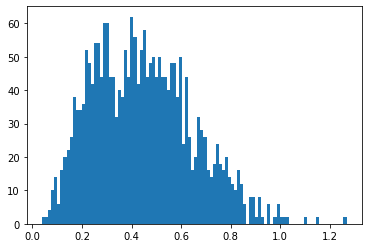

In [199]:
plt.hist(same_ds, bins=100);

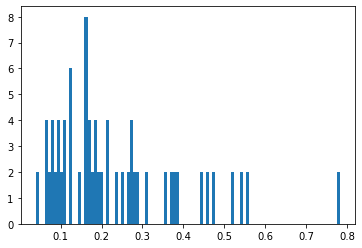

In [200]:
plt.hist(same_nuc, bins=100);

In [317]:
bcd = load_folder('/Users/michaelstadler/Desktop/tmp')

In [328]:
kernel_peak = 60_000
kernel = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/PSFs/psf_20220210_21x25x25pixels_100x50x50voxel.pkl')
kernel = ndi.zoom(kernel, (100/250, 50/85, 50/85), order=3)
kernel_adj = kernel * (kernel_peak / np.max(kernel))

In [329]:
nucs = bcd
n=0
c = np.sum(nucs[n]) / np.sum(kernel_adj) * 120

print('Convolution result: ' + str(c))

# nuc volume in cubic meters
v = np.count_nonzero(nucs[1].flatten()) * 250e-9 * 85e-9 * 85e-9

# nuc vol in liters
v = v * 1000

# peak 50 nM 

g = 50e-9 * 6.022e23 * v

print('50 nM result: ' + str(g))

Convolution result: 11337.434149526596
50 nM result: 5778.586808062499


In [355]:
kernel_peak = 10
kernel = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/PSFs/psf_20220210_21x25x25pixels_100x50x50voxel.pkl')
kernel = ndi.zoom(kernel, (100/250, 50/85, 50/85), order=3)
kernel_adj = kernel * (kernel_peak / np.max(kernel))

In [356]:
mask = Sim.make_spherical_mask(34,100,100, 5) * kernel_peak
cv = ndi.convolve(mask, kernel)
np.sum(cv) / np.sum(kernel_adj)

326.41252036371594

In [358]:
np.count_nonzero(mask.flatten())

485

In [347]:
fm.viewer(mask, 5)

interactive(children=(Dropdown(description='Color', index=4, options=('gray', 'inferno', 'prism', 'plasma', 'c…